In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.metrics import silhouette_score

%matplotlib inline

# Review

## Gaussian Mixture Models

Expectation Maximization with Gaussian Mixture Models (we'll call it EM for short here) is a clustering algorithm that's similar to k-means except it doesn't assume spherical variance within clusters. That means clusters can be ellipses rather than just sphereical. For example the graph on the left shows roughly spherical clusters, whereas the graph on the right shows non-spherical clusters.

<img src="https://drive.google.com/uc?export=view&id=1BslkqKXSuxYNcpAhFLlsVsBSdWUCWY3W"/>

The process for fitting EM is similar to k-means except for two main differences:

1. Instead of estimating ONLY cluster means/centers, we also estimate the variance for each predictor.
2. Instead of hard assignment (where each data point belongs to only 1 cluster), GMMs use soft assignment (where each data point has a probability of being in EACH cluster). 
    - because there is no hard assignment, the cluster centers/means and variances are calculated using EVERY data point weighted by the probability that the data point belongs to that cluster. Data points that are unlikely to belong to a cluster barely affect the center/mean and variance of that cluster, whereas data points that are very likely to belong to a cluster have a larger influence on the center/mean and variance of that cluster.

This means that when clusters are NOT spherical, EM will be able to accomodate that, while k-means will not.


## Math Math Math

### K-Means

#### Distortion
Distortion is a loss function for K-Means. It measures how far away data points are from their cluster center. We want points to be close to their cluster centers (cohesion).

$$ J = \sum_{n=1}^N \sum_{k=1}^K r_{nk}  \lVert x_n - \mu_k \rVert^2 $$

For K-means, $r_{nk}$ is 0 if the data point is *not* in cluster $k$ and 1 if the data point is in cluster $k$. Let's look at what happens to $J$ in different scenarios:

- if $x_n$ is a good fit for it's cluster, it will be pretty close to $\mu_k$ and the distance $\lVert x_n - \mu_k \rVert^2$ will be **small**.
- if $x_n$ is a bad fit for it's cluster, it will be far from $\mu_k$ and the distance $\lVert x_n - \mu_k \rVert^2$ will be **big**.
- for all clusters that $x_n$ is not a member of, $r_{nk}$ will be 0, so it does not matter what the distance $\lVert x_n - \mu_k \rVert^2$ is, because it will be multiplied by 0.

We want to choose cluster **centers** (called **centroids**) and cluster **assignments** that minimize the distortion $J$. 

#### Optimizing $J$

Because we want to minimize $J$, we take the **derivative** of $J$ with respect to $\mu_k$, set it to 0, and solve and find that the optimal cluster center is the *mean* of all the points in that cluster.

$$ \mu_k = \frac{\sum_{n = 1}^N r_{nk}x_n}{\sum_{n = 1}^N r_{nk}} = \frac{1}{N_k} \sum_{n=1}^{N} r_{nk}x_n$$

### Gaussian Mixture Models

#### Mixtures

A Mixture Model is a model that assumes our data comes from multiple distributions, all mixed together. Mathematically that looks like:

$$p(x) = \sum_{k=1}^K w_k * p_k(x)$$

Which tells us that each distribution $p_k(x)$ has some weight $w_k$. The higher $w_k$ the more data comes from distribution $k$. Our overall distribution is just a sum of each of these distributions.

As the name implies, **Gaussian** Mixture Models assume that our distributions (i.e. clusters) are Gaussian/Normal Distribitons. So $p_k(x)$ is a normal distribution. We often represent that using this formula:

$$ \mathcal{N}(x | \mu_k, \Sigma_k)$$

Which is just notation meaning a multivariate normal distribution with mean = $\mu_k$ and covariance = $\Sigma_k$. This means our GMM assumes that our clusters are each multivariate normal distributions, and they're all mixed together with different weights $w_k$. The larger $w_k$ the more points are likely to be in that cluster.

$$ p(x) = \sum_{k=1}^K w_k *\mathcal{N}(x | \mu_k, \Sigma_k)$$


#### Likelihood Function

Just like with Linear and Logistic Regression, we have a likelihood for GMM. The Likelihood measures how *likely* our data points are given the various parameters ($\mu_k$, $w_k$, and $\Sigma_k$) we have. The likelihood for the GMM model is the product of the likelihoods for each individual data point:

$$ \underbrace{p(\mathbf{X} | \mathbf{w}, \mu, \Sigma)}_\text{likelihood} = \prod_{n = 1}^N \sum_{k=1}^K w_k \mathcal{N}(x_n | \mu_k, \Sigma_k)$$

As we discussed in our Logistic Regression Classwork, it's difficult to take the derivative of a product, so we often take the *log* of the likelihood to make the math easier. Logs turn *products* into *sums*, and the optima of the log of a function are the same as the optima of the function. This gives us the **log-likelihood**:

$$log(p(\mathbf{X} | \mathbf{w,\mu, \Sigma})) = \sum_{{\color{Red} n} = 1}^{N}log\left\{ \sum_{{\color{Blue} k} = 1}^{K} w_{{\color{Blue} k}}\hspace{0.1in}\mathcal{N}(x_{{\color{Red} n}} | \mu_{{\color{Blue} k}}, \Sigma_{{\color{Blue} k}})\right\}$$

We want to maximize this function!

#### EM

One way to find maximum likelihood solutions is called **Expectation Maximization**, or **EM** for short. Setting the derivative of the log-likelihood with respect to $\mu_k$ to 0, and solving, we find that the optimal value for $\mu_k$ at each step should be:

$$ \mu_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} x_n $$

Where $N_k$ is the sum of the responsibilities of each point for cluster $k$. Remember, responsibilities tell you how likely it is that a data point $x_n$ is in cluster $k$. If a lot of points are likely to be in cluster $k$, $N_k$ will be big. In that sense, $N_k$ is a proxy for the *size* of cluster $k$. 

Setting the derivative of the log-likelihood with respect to $\Sigma_k$ to 0, and solving, we find that the optimal value for $\Sigma_k$ at each step should be:

$$ \Sigma_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} (x_n-\mu_k)(x_n-\mu_k)^T $$

and finally, if we set the derivative of the log-likelihood with respect to $w_k$ to zero and solve, we find that the optimal value for the mixing weights $w_k$ is:

$$w_k = \frac{N_k}{N}$$

where $N$ is the number of data points.

## Math Takeaways
We don't do math just because it's fun, we do it to help you understand the algorithm! So here are some takeaways this math should help you understand: 

- GMM does soft assignment, every data point belongs to every cluster with some probability
- Data points that are more likely to be in a cluster have more influence over its parameters
- GMM uses the EM algorithm to iteratively update the cluster distributions. It first assigning a responsibility to each data point (E-step), and then using them to calculate weighted means and variances for each cluster (M-step)
- Responsibilities measure the probability of a data point being in each cluster (technically the posterior probability).
- Responsibilities contain information about how common a cluster is as well as the likelihood of a data point belonging to that cluster 


## `sklearn`

Let's re-do our spotify clustering model from the K-means classwork using GMM.

0.20921462378157568


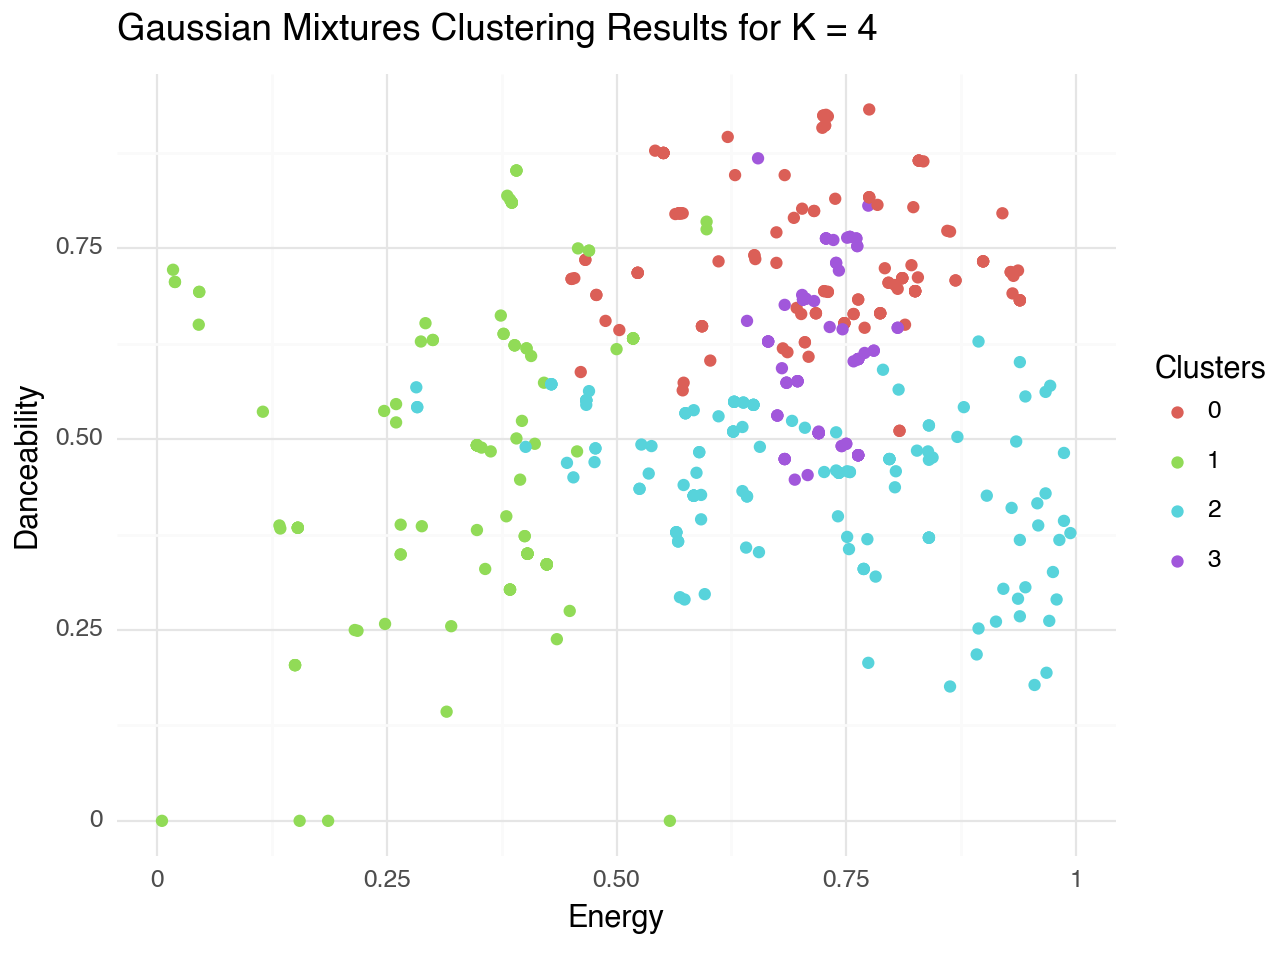

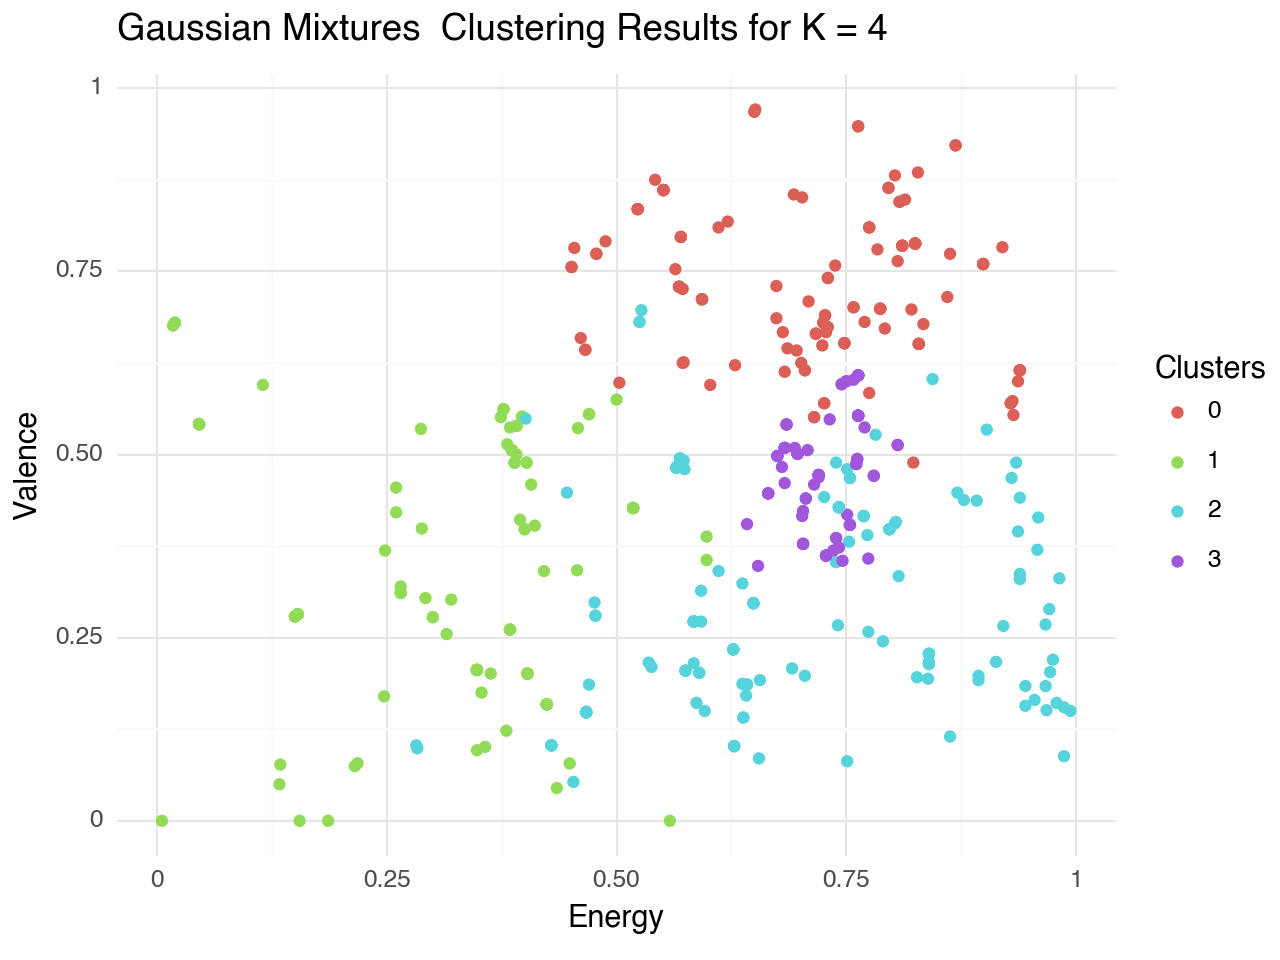

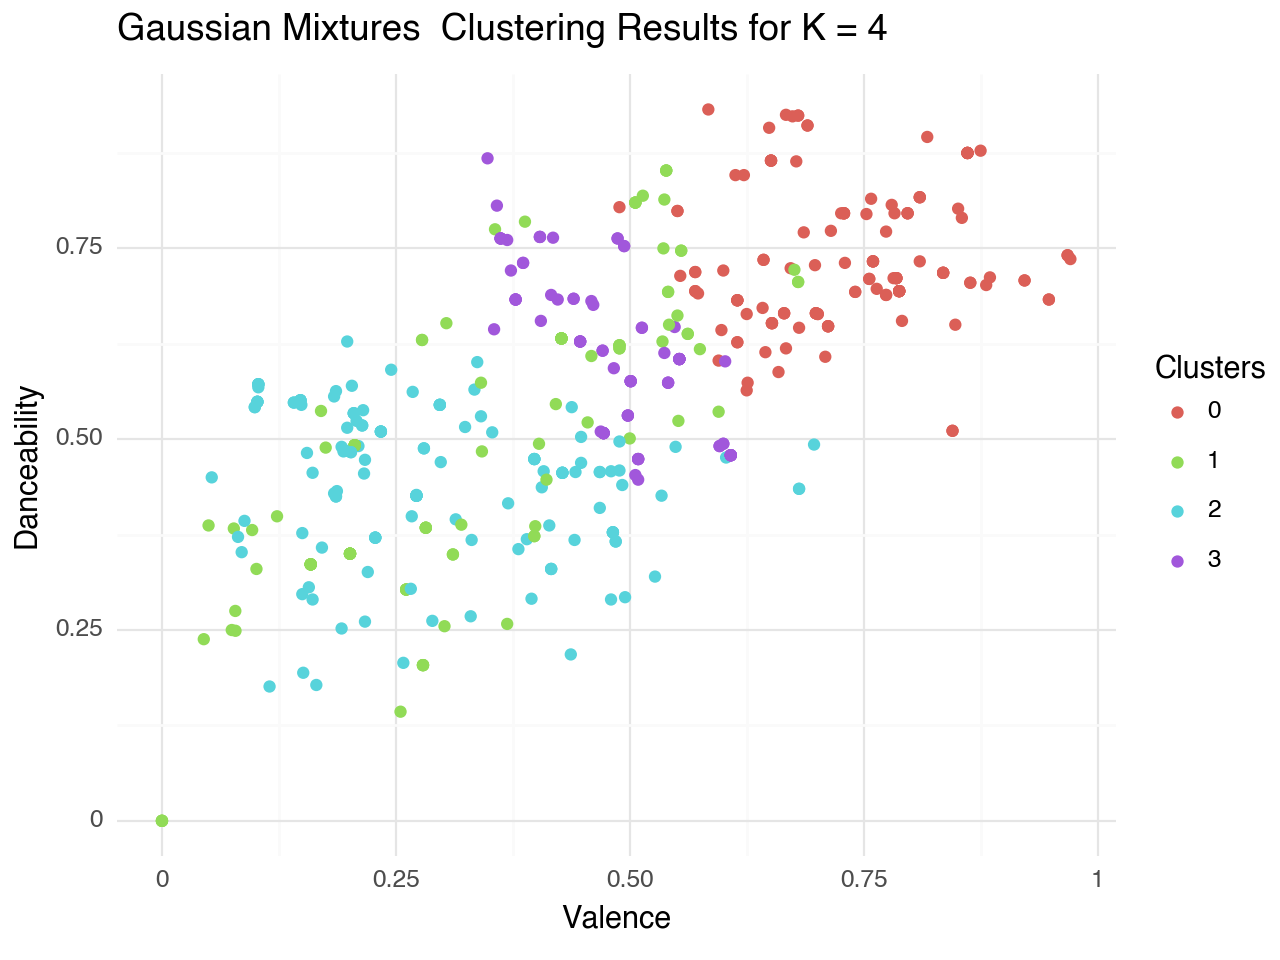

In [38]:
#### STEP 1. ####
bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")
bey.head()

predictors = ["energy", "danceability", "valence"]


X = bey[predictors]

#### STEP 2. ####
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

#### STEP 3. ####
gmm = GaussianMixture(n_components = 4)
pipe = Pipeline([("z", z), ("clust", gmm)])

#### STEP 4. ####
labels = pipe.fit_predict(X)

#### STEP 5. ####
print(silhouette_score(X, pipe.predict(X)))
X["clusters"] = labels

print(ggplot(X, aes(x = "energy", y = "danceability", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Danceability", title = "Gaussian Mixtures Clustering Results for K = 4",
         color = "Clusters"))
print(ggplot(X, aes(x = "energy", y = "valence", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Valence", title = "Gaussian Mixtures  Clustering Results for K = 4",
         color = "Clusters"))
print(ggplot(X, aes(x = "valence", y = "danceability", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Valence", y = "Danceability", title = "Gaussian Mixtures  Clustering Results for K = 4",
         color = "Clusters"))


## BIC
Like with K-Means, sometimes we don't know how many clusters to use! While you can still calculate silhouette scores for GMM clusters, becuase GMM allows oblong clusters (shaped like ellipses), cohesion/separation might not always be the best measure of how good the clusters are (see `d3` below).

Another measure of cluster performance is the [**Bayesian Information Criterion**](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/mixture/_gaussian_mixture.py#L862) (BIC). The BIC measures how well fit your model is, where **lower** values of BIC are better.

$$ BIC = \underbrace{- 2 log(\hat{L})}_\text{goodness of fit} + \underbrace{k*log(N)}_\text{complexity penalty} $$

- $\hat{L}$ is the maximum likelihood of the model ($\prod_{n = 1}^N \sum_{k=1}^K w_k \mathcal{N}(x_n | \mu_k, \Sigma_k)$; from above)
- $N$ is the number of data points
- $k$ is the *number of parameters* in the model (just remember, the more clusters, the more parameters)

When a clustering solution is *good* it's likelihood will be *high*. So $-2 log(\hat{L})$ will be *low*. BIC also **penalizes complexity** by adding on the $k*log(N)$ term. The more parameters we have to estimate ($k$) the higher $k*log(N)$ will be, thus BIC *penalizes* models for having a lot of parameters. If adding parameters doesn't improve the fit of the model (measured by $- 2 log(\hat{L})$), we don't want them. This is similar to **LASSO** and **Ridge** penalties, where we have to have things "pull their weight" in order for them to be "worth" the penalty.


🚨 So in summary, we choose models with lower BIC values.
 


## Another `sklearn` Example
 
 Just like we did with SSE and silhouette scores in K-Means, let's use BIC to choose the number of clusters for the **wine** dataset.




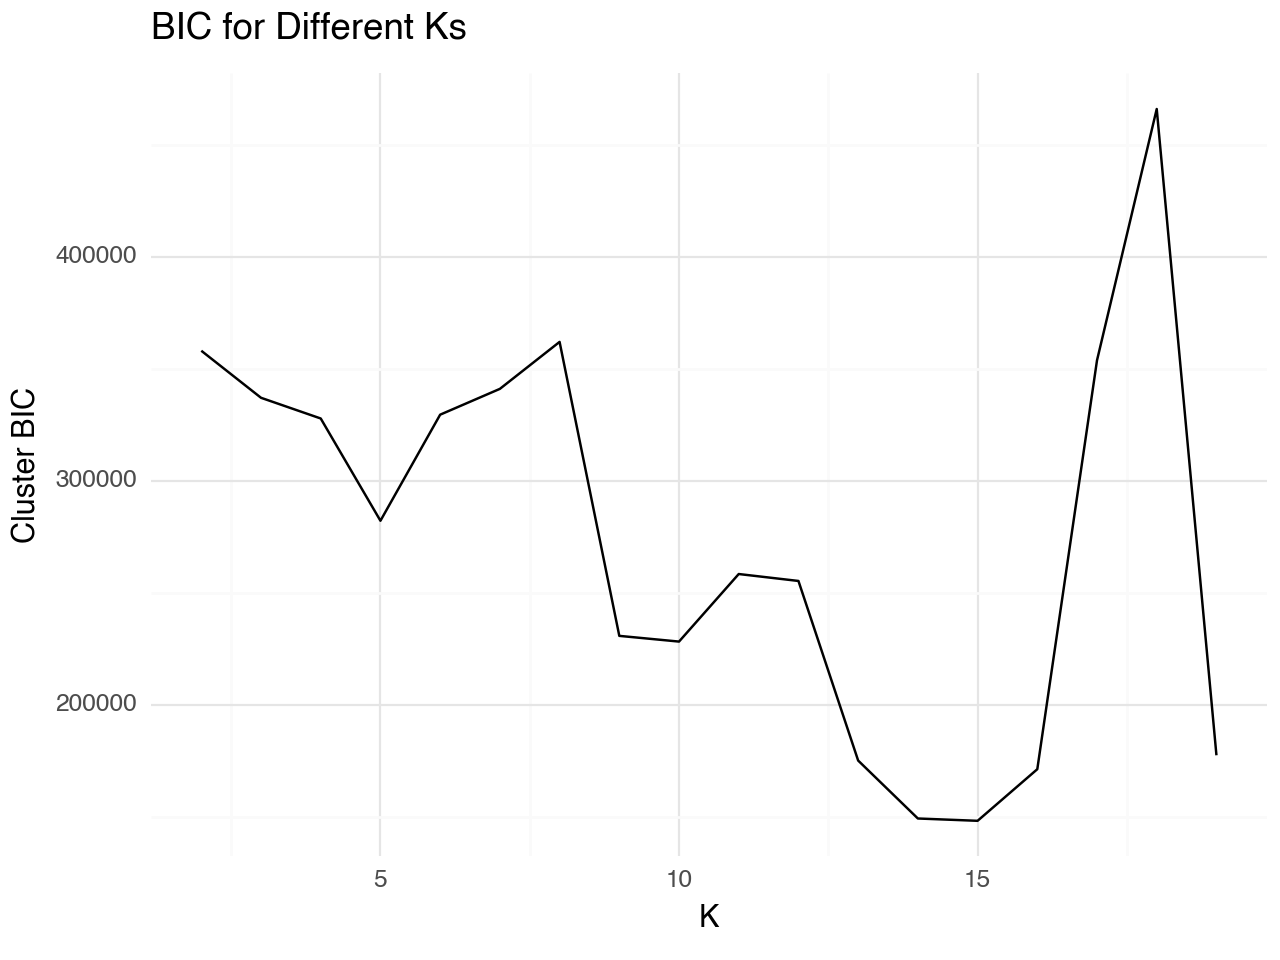

In [42]:
wine = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/wineLARGE.csv")

# drop and reset rows
wine.dropna(inplace = True)
wine.reset_index(inplace = True)

# grab data we want to cluster
feats = ["citric.acid", "residual.sugar"]

X = wine[feats]

# create empty model
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

metrics = {"BIC": [], "k": []}

for i in range(2,20):
    gmm = GaussianMixture(i)
    pipe = Pipeline([
        ("pre", z),
        ("gmm", gmm)
    ])
    
    labels = pipe.fit_predict(X[feats])
    bic_val = pipe.named_steps["gmm"].bic(X[feats])

    metrics["BIC"].append(bic_val)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

print(ggplot(df, aes(x = "k", y = "BIC")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Cluster BIC",
         title = "BIC for Different Ks"))


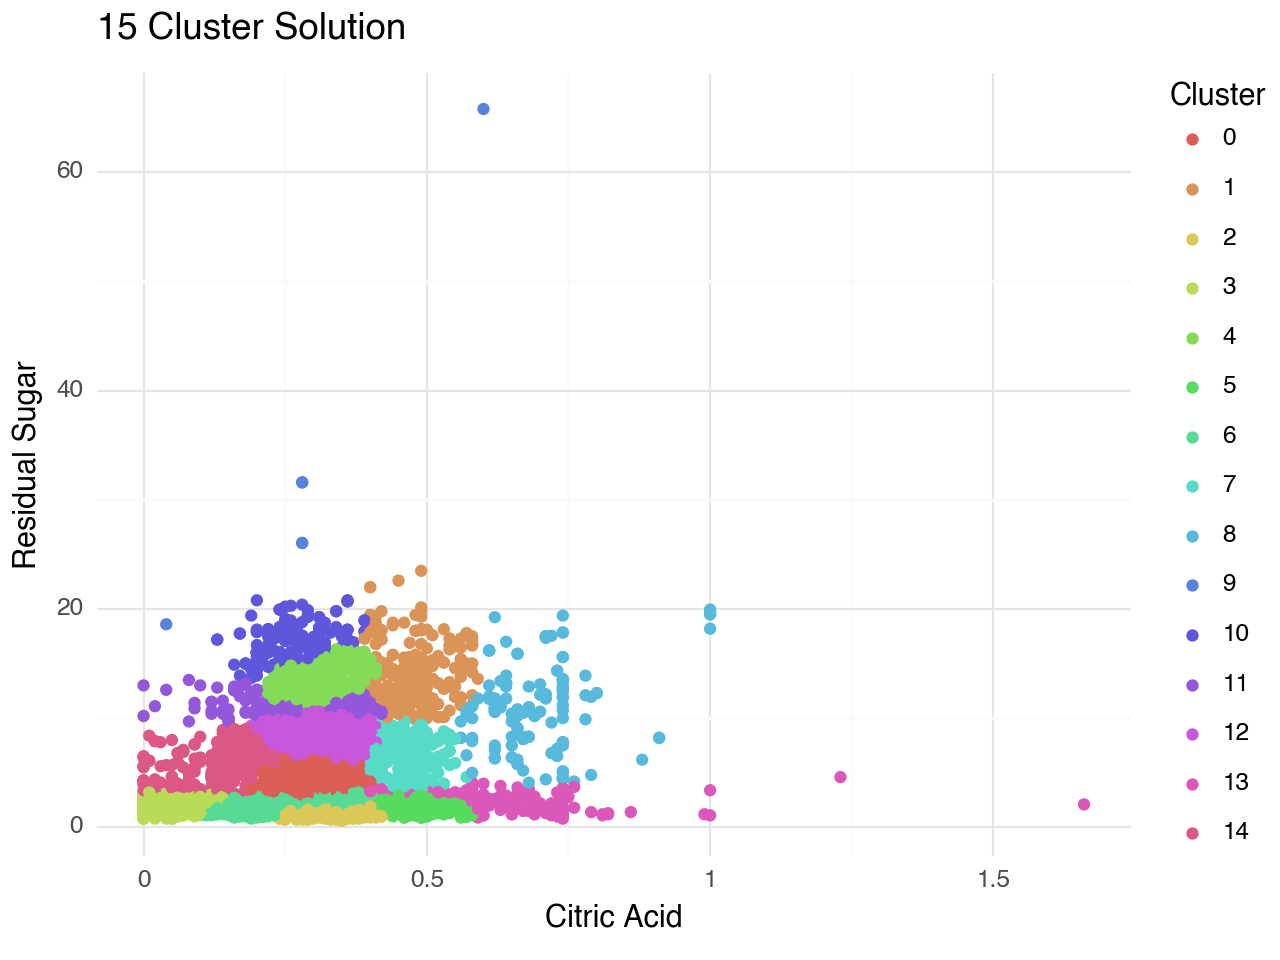

In [44]:
gmm = GaussianMixture(15)
pipe = Pipeline([
      ("pre", z),
      ("gmm", gmm)
])
labels = pipe.fit_predict(X[feats])

X["cluster"] = labels
print(ggplot(X, aes(x = "citric.acid", y = "residual.sugar", color = "factor(cluster)")) +
      geom_point() +
      theme_minimal() + 
      scale_color_discrete(name = "Cluster") + 
      labs(x = "Citric Acid", 
           y = "Residual Sugar",
           title = "15 Cluster Solution"))

# Classwork 

Now, you're going to fit multiple clustering algorithms on each dataset below.

For each dataset: 
- Make a ggplot of the data
- fit a K-Means Model
- fit a GMM 
Either choose k by making a plot and using your own judgement, or by trying out different k's and seeing which works best using the BIC.

See how well GMM and KM perform. Do both do well? Does one do better than the other? Do both do poorly?

##  Very Distinct Clusters

In [ ]:
d3 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/GMM_Classwork_01.csv")

# perform K-Means


In [ ]:
# perform GMM


## Cluster in Cluster

In [ ]:
d2 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM4.csv")

# perform K-Means


In [ ]:
# perform GMM


## Oblong Clusters

In [ ]:
d3 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/GMM_Classwork_02.csv")

# perform K-Means



In [ ]:
# perform GMM

## Clusters with Different Variance

In [ ]:
d4 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/GMM_Classwork_03.csv")
# perform K-Means

In [ ]:
# perform GMM

## Uneven Sized Clusters

In [ ]:
d5 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/GMM_Classwork_04.csv")
# perform K-Means

In [ ]:
# perform GMM

##  Reflection

What cautions will you now take when doing K-Means? In other words, what issues did this classwork present that might change how you apply clustering to real data?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

## Cluster Stability

You may have already noticed this, but K-Means and EM will often give different solutions each time it runs. Run the following cells multiple times and notice how different (or not) the results are. What do you think could cause this instability?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

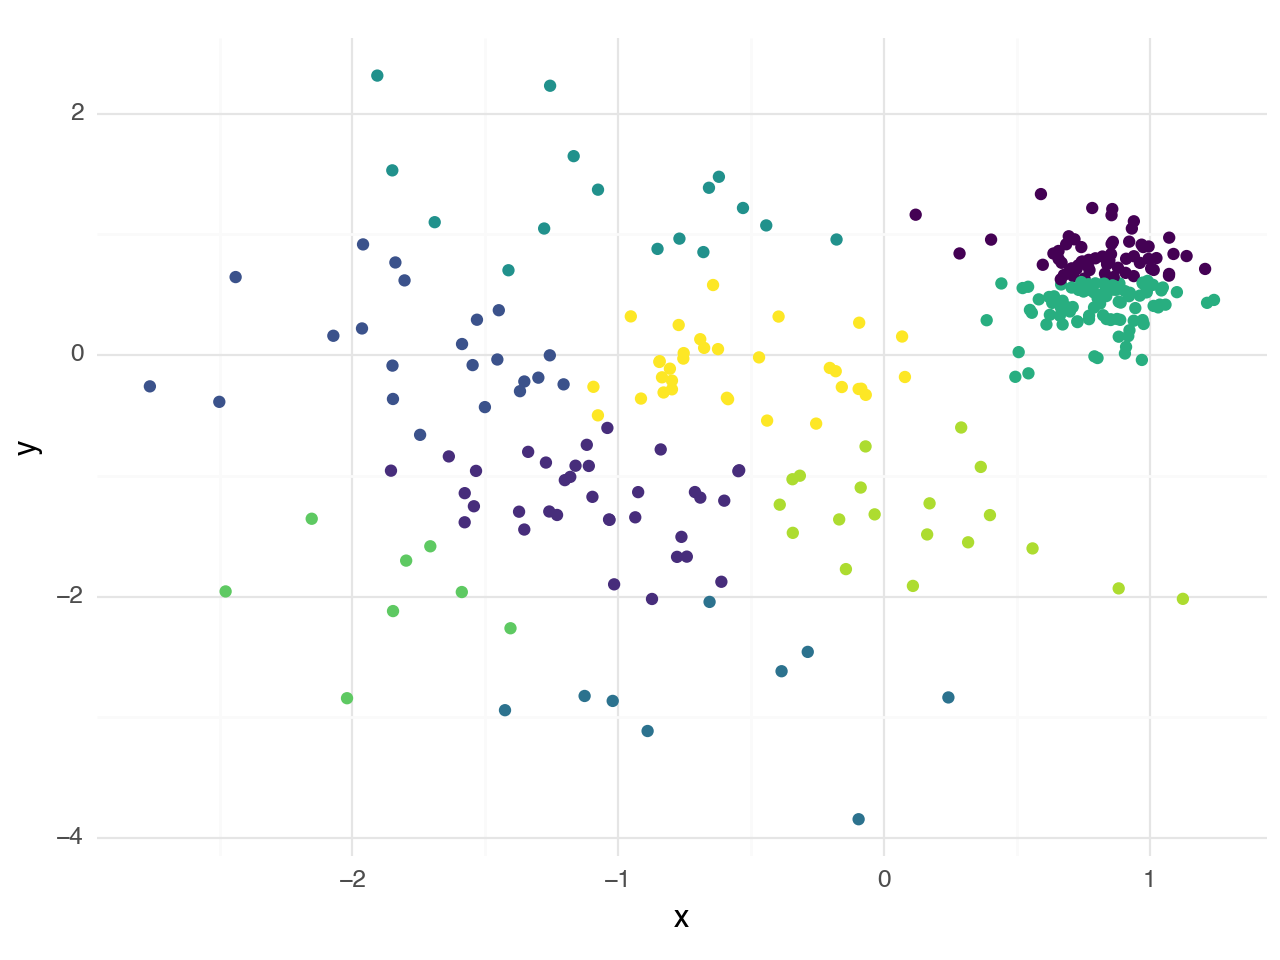

<Figure Size: (640 x 480)>

In [25]:
d6 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM6.csv")

feat = ["x", "y"]

z = make_column_transformer((StandardScaler(), feat))

KM = KMeans(n_clusters = 9)

pipe = Pipeline([
    ("pre", z),
    ("cluster", KM)
])

pred = pipe.fit_predict(d6[feat])

ggplot(d6, aes("x", "y", color = pred)) + geom_point() + theme_minimal() + theme(legend_position = "none")

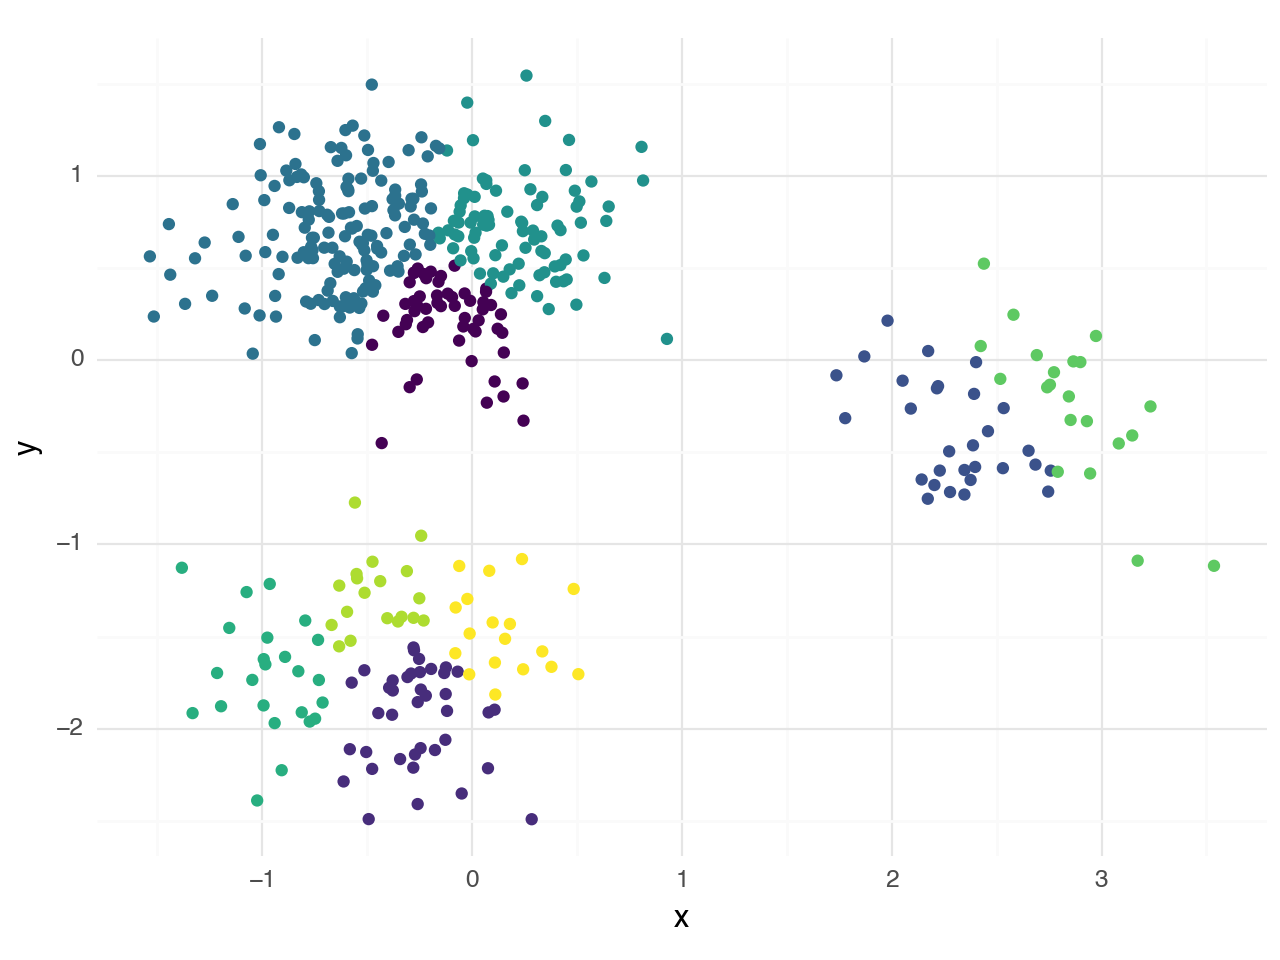

<Figure Size: (640 x 480)>

In [35]:
d7 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KMEM5.csv")

feat = ["x", "y"]

z = make_column_transformer((StandardScaler(), feat))

KM = GaussianMixture(n_components = 9)

pipe = Pipeline([
    ("pre", z),
    ("cluster", KM)
])

pred = pipe.fit_predict(d7[feat])

ggplot(d7, aes("x", "y", color = pred)) + geom_point() + theme_minimal() + theme(legend_position = "none")

# Chelsea's Thoughts

I hope this classwork doesn't scare you away from clustering. Clustering is an incredibly useful tool! However, it's not a perfect tool, and like all the other models we've learned, you have to be careful and thoughtful in how you apply it. 

I love [this](https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means/133694#133694) stackOverflow thread about k-means if you want to delve deeper.